In [33]:
from utils import *

In this analysis, we target the Waggle node [W02F](https://portal.sagecontinuum.org/node/000048B02D15BDC2) and look for all plugin runs in the last day.

In [34]:
df = fill_completion_failure(parse_events(get_data("w02f", start="-1d")))

We examine names of the plugins and their count of succeeded runs. Any failed plugin runs are not considered for this analysis.

In [35]:
grouped_by_plugin = df[df["end_state"] == "completed"].groupby("plugin_task")
grouped_by_plugin.size()

plugin_task
imagesampler-left       18
imagesampler-right      21
object-counter-left     24
object-counter-right    38
dtype: int64

We pick `imagesampler-left` plugin to analyze its performance.

Now, we print a few Kubernetes pod (i.e., an instance) names of the plugin. The names consists of plugin name and random-like characters at the tail. Each of the pod names represents a particular run of the plugin.

In [37]:
object_counter_left = grouped_by_plugin.get_group("object-counter-left")
object_counter_left["k3s_pod_name"].head()

127    object-counter-left-sf7k6
132    object-counter-left-vk9q9
137    object-counter-left-5ps7w
142    object-counter-left-shs2q
147    object-counter-left-9d6t2
Name: k3s_pod_name, dtype: object

Statistics of their execution time can be obtained as follows,

In [38]:
object_counter_left["runtime"].describe()

count                           24
mean     0 days 00:02:35.754127178
std      0 days 00:00:53.913398980
min      0 days 00:01:17.713955847
25%      0 days 00:01:57.065659805
50%      0 days 00:02:23.701895682
75%      0 days 00:03:29.431627633
max      0 days 00:04:34.907632266
Name: runtime, dtype: object

__NOTE: To get performance data of the plugin, we will need to access to the database inside the node. Obtaining the data from the database will require a user permission. Please [contact us](https://docs.waggle-edge.ai/docs/contact-us) if you need to do this analysis on your own.__

Below cell creates a bash script that can be run on the "W02F" Waggle node. This will create multiple CSV files, each of them represents performance data of the instance. After running it, you can copy the CSVs over to your laptop.

In [39]:
script = """#!/bin/bash
"""
for _, r in object_counter_left.iterrows():
    script += f'pluginctl profile get {r["k3s_pod_name"]} --start "{r["timestamp"].isoformat()}" --end "{r["completed_at"].isoformat()}"\n\n'

print(script)

#!/bin/bash
pluginctl profile get object-counter-left-sf7k6 --start "2022-11-21T04:15:09.338281495+00:00" --end "2022-11-21T04:17:13.955714767+00:00"

pluginctl profile get object-counter-left-vk9q9 --start "2022-11-21T05:15:09.554871239+00:00" --end "2022-11-21T05:19:01.648558179+00:00"

pluginctl profile get object-counter-left-5ps7w --start "2022-11-21T06:15:09.610868163+00:00" --end "2022-11-21T06:17:17.357443579+00:00"

pluginctl profile get object-counter-left-shs2q --start "2022-11-21T07:15:09.756605513+00:00" --end "2022-11-21T07:17:08.322547697+00:00"

pluginctl profile get object-counter-left-9d6t2 --start "2022-11-21T08:15:09.226547378+00:00" --end "2022-11-21T08:17:46.452132392+00:00"

pluginctl profile get object-counter-left-zhmdr --start "2022-11-21T09:15:09.276359344+00:00" --end "2022-11-21T09:17:03.553865585+00:00"

pluginctl profile get object-counter-left-hzzxz --start "2022-11-21T10:15:09.363782425+00:00" --end "2022-11-21T10:17:39.754077545+00:00"

pluginctl profi

Once you copied all CSVs for the plugin, it is time to analyze performance of it. Each CSV file contains different metrics about the plugin instance. We will use the following functions to process the file and extract metrics we want to analyze.

In [40]:
import os
import datetime 
import pandas as pd
from glob import glob
import matplotlib.pyplot as plt

In [104]:
# Metrics to look at
METRIC_CONTAINER_START_EPOCH = "container_start_time_seconds"
METRIC_CPU_USAGE_SECOND = "container_cpu_usage_seconds_total"
METRIC_MEMORY_USAGE_BYTES = "container_memory_usage_bytes"
METRIC_FS_READS_BYTES_TOTAL = "container_fs_reads_bytes_total"
METRIC_FS_WRITES_BYTES_TOTAL = "container_fs_writes_bytes_total"
METRIC_GPU_LOAD1S = "sys.metrics.gpu.average.1s"

In [113]:
def get_time_and_value(line):
    sp = line.split(",")
    return pd.Timestamp(sp[5]), float(sp[6])

def load_metric(file, name: str):
    container_start_t = -1
    metric = []
    with open(file) as f:
        for l in f:
            if name in l:
                metric.append((get_time_and_value(l)))
            elif container_start_t < 0 and METRIC_CONTAINER_START_EPOCH in l:
                container_start_t = get_time_and_value(l)[1]
    if container_start_t == -1:
        raise Exception("Couldn't find container start time")
    a = datetime.datetime.utcfromtimestamp(container_start_t)
    metric.insert(0, (pd.to_datetime(a, utc=True), 0.))
    return pd.DataFrame(metric, columns=["timestamp", "value"])

def create_since(df):
    df["td"] = df.timestamp.diff().dt.total_seconds()
    df.at[0, "td"] = 0.
    df["since"] = df.td.cumsum()
    return df

def load_cpu(file):
    cpu = load_metric(file, METRIC_CPU_USAGE_SECOND)
    cpu = create_since(cpu)
    cpu["vd"] = cpu.value.diff(periods=1)
    cpu.at[0, "vd"] = 0.
    cpu["cpu_util"] = cpu.vd / cpu.td * 1000.
    cpu.at[0, "cpu_util"] = 0.
    return cpu

def load_mem(file):
    mem = load_metric(file, METRIC_MEMORY_USAGE_BYTES)
    mem = create_since(mem)
    mem["value_in_M"] = mem.value / 1024 / 1024
    return mem

def load_gpu(file):
    gpu = load_metric(file, METRIC_GPU_LOAD1S)
    gpu = create_since(gpu)
    gpu["gpu_util"] = gpu.value * 1000.
    return gpu

def get_perf(file):
    cpu = load_cpu(file)
    mem = load_mem(file)
    gpu = load_gpu(file)
    return cpu, mem, gpu

def show_plot(file, duration=120):
    cpu, mem, gpu = get_perf(file)
    plt.close("all")
    plt.figure()
    cp = cpu.plot(x="since", y="cpu_util", style=["o-r"], label="CPU", ylim=[0., 2000.], xlim=[0, duration])
    cp.set_ylabel("CPU/GPU (Millicore)")
    if len(gpu.index) > 0:
        gp = gpu.plot(x="since", y="gpu_util", style=["b"], label="GPU", ax=cp, secondary_y=False)
        mp = mem.plot(x="since", y="value_in_M", style=["^-g"], label="Memory", ax=gp, secondary_y=True)
        mp.set_ylim([0., 4000.])
    else:
        mp = mem.plot(x="since", y="value_in_M", style=["^-g"], label="Memory", ax=cp, secondary_y=True)
    mp.set_ylabel("Memory (MiB)")
    cp.set_xlabel("epoch (Second)")
    cp.grid(which="both", axis="both")
    plt.show()

def show_plot_of_instances(plugin_name, base_path="./", duration=120):
    path = os.path.join(base_path, plugin_name)
    _, ax = plt.subplots(3, 1)
    for file in glob(f'{path}-*'):
        cpu, mem, gpu = get_perf(file)
        ax[0].plot(cpu["since"], cpu["cpu_util"], "r", label="CPU")
        ax[1].plot(mem["since"], mem["value_in_M"], "g", label="Memory")
        ax[2].plot(gpu["since"], gpu["gpu_util"], "b", label="GPU")
    ax[0].set_ylim([0., 2000.])
    ax[0].set_ylabel("CPU (Millicore)")
    ax[1].set_ylim([0., 3000.])
    ax[1].set_ylabel("Memory (MiB)")
    ax[2].set_ylim([0., 1000.])
    ax[2].set_ylabel("GPU Percentage")
    plt.setp(ax, xlim=[0., duration])
    plt.show()


We call the "show_plot_of_instances" function to plot measured resource consumption by the plugin instances. This will allow us to visually inspect how much CPU, Memory, and GPU were utilized by the plugin instances.

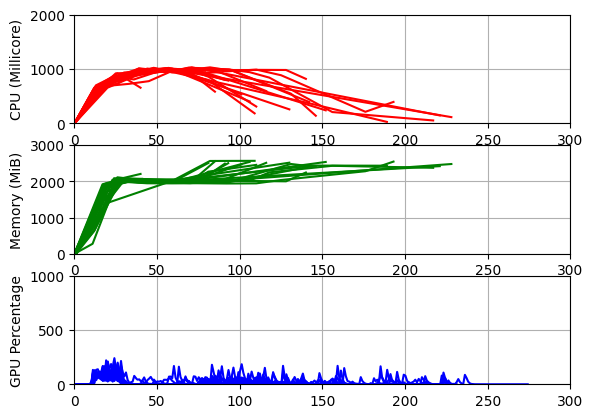

In [114]:
show_plot_of_instances("object-counter-*", base_path="/tmp", duration=300)

It looks that the plugin used about 1000 millicores of CPU, up to 2.5 GB of memory, and about 10-20 % of GPU over the plugin runtime.